In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

from Psilocybin.subjects import get_psi_dir

# These are crucial parameters - otherwise all text gets output with each letter in a word or heading as a separate unit
# instead of a text box
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Specify Arial as font type - also crucial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/xarray/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Specify desired place to plot here.
plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Manuscripts/Psilocybin/plots")

## Specify plotting parameters

In [3]:
animals = ["Finn", "Rey", "Rose", "Finn2"]
rasterize_scatter = True # This is crucial, default (False) will produce unweildy plots

In [20]:
ripple_thresh = 2.5 # 2.5 or 4

# Cut down Finn2 saline to 1hr?
chop_finn2_saline = False  # True = only use 1st hour of Finn2 saline, False = use all
finn2_append = "_1hrsalineonly" if chop_finn2_saline else ""

# ... OR only use 1hr Psilocybin for all
limit_to_1st_hr = True
chop_all_append = "_allsessions1hr" if limit_to_1st_hr else ""
finn2_append = "" if chop_all_append else finn2_append

## Load in data

In [21]:
df_grp = []
for ida, animal in enumerate(animals):
    file_use = get_psi_dir(animal, "Saline1").parent / "aggdata" / f"{animal.lower()}_rpl_features_thresh{'_'.join(str(ripple_thresh).split('.'))}{chop_all_append}.csv"
    df_animal = pd.read_csv(file_use, index_col=0)
    df_animal["Animal_name"] = animal
    df_animal["Animal"] = ida + 1
    df_grp.append(df_animal)

df_grp = pd.concat(df_grp, axis=0, ignore_index=True)
df_grp
    

,start,stop,peak_time,peak_power,peak_power_abs,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal_name,Animal
0,0.9184,0.9992,0.9712,28540.330,197.917961,0.0808,168.181818,NaN,13.609159,Saline 1,Finn,1
1,1.1328,1.1928,1.1664,22820.574,165.985808,0.0600,128.787879,NaN,6.622136,Saline 1,Finn,1
2,31.1544,31.2080,31.1832,18836.242,152.198043,0.0536,172.727273,NaN,13.090663,Saline 1,Finn,1
3,60.0312,60.0872,60.0600,25599.062,185.374544,0.0560,171.212121,NaN,8.519090,Saline 1,Finn,1
4,64.9136,65.0320,64.9408,23685.475,157.387900,0.1184,133.333333,NaN,10.264427,Saline 1,Finn,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17649,3576.4264,3576.4920,3576.4624,22421.720,129.521987,0.0656,124.242424,NaN,4.036974,Saline 2,Finn2,4
17650,3578.8744,3578.9472,3578.9248,19948.625,133.626620,0.0728,125.757576,NaN,3.909696,Saline 2,Finn2,4
17651,3581.0040,3581.0640,3581.0376,20226.541,143.985589,0.0600,172.727273,NaN,5.013565,Saline 2,Finn2,4
17652,3581.7976,3581.9920,3581.8400,38114.504,289.078805,0.1944,171.212121,NaN,12.025231,Saline 2,Finn2,4


In [22]:
# Get mean values for each metric
df_grp["session"] = pd.Categorical(df_grp["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])
df_mean = df_grp.groupby(["Animal_name", "session"]).mean(numeric_only=True)
df_mean

start         stop    peak_time    peak_power  \
Animal_name session                                                           
Finn        Saline 1    1897.440834  1897.569530  1897.505992  29440.270275   
            Psilocybin  1434.586752  1434.700811  1434.645162  40117.843012   
            Saline 2    1049.526244  1049.625710  1049.577504  21857.413679   
Finn2       Saline 1    1776.126822  1776.230334  1776.178194  21992.215779   
            Psilocybin  1572.918861  1573.026491  1572.973126  22688.059259   
            Saline 2    1664.216549  1664.321178  1664.268798  25662.820810   
Rey         Saline 1    1260.822826  1260.916462  1260.869781  20233.905461   
            Psilocybin  1269.288178  1269.403630  1269.346346  21032.132004   
            Saline 2    1574.670067  1574.765265  1574.719616  38748.317697   
Rose        Saline 1    1427.735231  1427.833649  1427.785368  24593.943506   
            Psilocybin  1213.309603  1213.422259  1213.365446  19505.949534   
            Saline 2    1374.586798  1374.695639  1374.641232  19045.320066   

                        peak_power_abs  duration  peak_frequency_bp  label  \
Animal_name session                                                          
Finn        Saline 1        207.839522  0.128696         159.445115    NaN   
            Psilocybin      265.589110  0.114059         158.893842    NaN   
            Saline 2        152.811627  0.099466         158.588058    NaN   
Finn2       Saline 1        159.260857  0.103512         163.581484    NaN   
            Psilocybin      159.750273  0.107630         161.498337    NaN   
            Saline 2        181.953059  0.104629         166.206777    NaN   
Rey         Saline 1        144.539112  0.093635         159.226217    NaN   
            Psilocybin      140.585635  0.115452         156.825298    NaN   
            Saline 2        272.633129  0.095198         171.278732    NaN   
Rose        Saline 1        180.570064  0.098418         164.400130    NaN   
            Psilocybin      139.156328  0.112656         158.277978    NaN   
            Saline 2        138.377572  0.108840         159.883117    NaN   

                        sharp_wave_amplitude  Animal  
Animal_name session                                   
Finn        Saline 1                5.629058     1.0  
            Psilocybin              5.503128     1.0  
            Saline 2                5.731728     1.0  
Finn2       Saline 1                4.911547     4.0  
            Psilocybin              5.154888     4.0  
            Saline 2                6.012975     4.0  
Rey         Saline 1                6.842761     2.0  
            Psilocybin              7.200885     2.0  
            Saline 2                7.232981     2.0  
Rose        Saline 1                7.274861     3.0  
            Psilocybin              4.620359     3.0  
            Saline 2                6.388267     3.0

In [23]:
# Get ripple counts as well
df_count = df_grp.loc[:, ["session", "Animal_name", "start"]].groupby(["Animal_name", "session"]).count()
df_count.rename(columns={"start": "rpl_count"})

rpl_count
Animal_name session              
Finn        Saline 1         1356
            Psilocybin        938
            Saline 2         1148
Finn2       Saline 1         1905
            Psilocybin       1676
            Saline 2         1219
Rey         Saline 1         1019
            Psilocybin       1171
            Saline 2         1615
Rose        Saline 1         1591
            Psilocybin       1916
            Saline 2         2100

In [24]:
# Compare to Ilknur data
ilknur_df = pd.read_csv("/Users/nkinsky/Documents/UM/Working/Psilocybin/Recording_Rats/SWR_all_animals_group_data.csv")
ilknur_mean = ilknur_df.groupby(["Animal_name", "session"]).mean(numeric_only=True)
ilknur_mean

start         stop    peak_time    peak_power  \
Animal_name session                                                           
Finn        Psilocybin  5311.166484  5311.267951  5002.439229  14479.054174   
            Saline 1    1897.440834  1897.569530  1897.505992  29440.270275   
            Saline 2    1049.526244  1049.625710  1049.577504  21857.413679   
Finn2       Psilocybin  8477.567291  8477.670442  6763.537050  12712.391880   
            Saline 1    5482.153839  5482.253801  4762.102313  14452.543474   
            Saline 2    8065.632859  8065.779085  7079.046945  15014.175472   
Rey         Psilocybin  4567.784063  4567.886980  3441.930470  13005.217392   
            Saline 1    1260.822826  1260.916462  1260.869781  20233.905461   
            Saline 2    2443.456688  2443.551181  2443.505263  23943.087559   
Rose        Psilocybin  1705.573710  1705.684910  1026.252186  13848.925857   
            Saline 1    1895.611943  1895.701165  1218.051557  14148.570416   
            Saline 2    2091.294416  2091.390310  1413.795973  13725.984162   

                        duration  peak_frequency_bp  label  \
Animal_name session                                          
Finn        Psilocybin  0.101467         133.886798    NaN   
            Saline 1    0.128696         159.445115    NaN   
            Saline 2    0.099466         158.588058    NaN   
Finn2       Psilocybin  0.103152         136.084841    NaN   
            Saline 1    0.099961         139.938662    NaN   
            Saline 2    0.146226         136.410717    NaN   
Rey         Psilocybin  0.102918         134.794491    NaN   
            Saline 1    0.093635         159.226217    NaN   
            Saline 2    0.094493         166.328731    NaN   
Rose        Psilocybin  0.111200         141.504329    NaN   
            Saline 1    0.089223         142.175602    NaN   
            Saline 2    0.095894         140.983856    NaN   

                        sharp_wave_amplitude  Animal  
Animal_name session                                   
Finn        Psilocybin              5.584987     1.0  
            Saline 1                5.629058     1.0  
            Saline 2                5.731728     1.0  
Finn2       Psilocybin              5.438357     4.0  
            Saline 1               13.459705     4.0  
            Saline 2               63.499876     4.0  
Rey         Psilocybin              6.524651     2.0  
            Saline 1                6.842761     2.0  
            Saline 2                7.010372     2.0  
Rose        Psilocybin              9.403042     3.0  
            Saline 1                9.314121     3.0  
            Saline 2                4.827821     3.0

In [ ]:
ilknur_m

## Plotting template here with appropriate size graphics and parameters

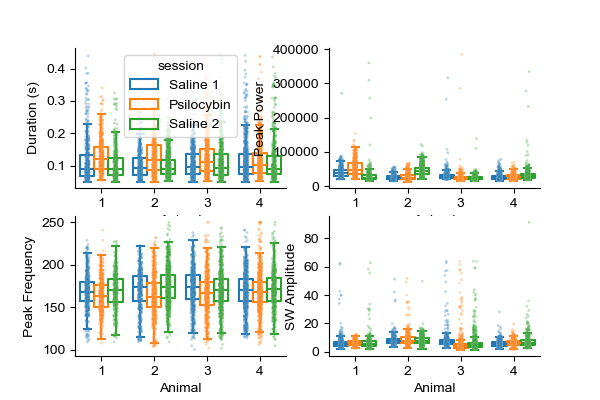

In [15]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
titles = ["Duration (s)", "Peak Power", "Peak Frequency", "SW Amplitude"]
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
for idf, feature in enumerate(features):
    ax = axs.reshape(-1)[idf]
    plot_legend = True if idf == 0 else False
    sns.boxplot(data=df_grp, x="Animal", y=feature, dodge=True, hue="session", showfliers=False, fill=False, 
                legend=plot_legend, ax=ax)
    sns.stripplot(data=df_grp, x="Animal", y=feature, dodge=True, hue="session", size=2, 
                  linewidth=0.1, edgecolor="w", alpha=0.3, rasterized=rasterize_scatter,
                  legend=False, ax=ax)
    ax.set_ylabel(titles[idf])
    sns.despine(ax=ax)

fig.savefig(plot_dir / "ripple_features.pdf", dpi=600)

## Other investigations / experimental plots below

### Investigate Rose Psilocybin session - why are peak frequency and power off by so much?!?

In [ ]:
df_rose = df_grp[df_grp.Animal == "Rose"]
df_rose_psi = df_rose[df_rose.session == "Psilocybin"]
_, ax = plt.subplots()
ax.plot(df_rose_psi.peak_time, df_rose_psi.peak_power)

In [ ]:
_, ax = plt.subplots()
sns.lineplot(data=df_mean, x="session", y="duration", hue="Animal", ax=ax)

FEATURE: duration
Saline 1 mean = 0.11184608733247055, Psilocybin mean = 0.1258749704375244
Mann-Whitney U test p-value=8.01567678153805e-31

Psilocybin mean = 0.1258749704375244, Saline 2 mean = 0.10796791277258881
Mann-Whitney U test p-value=1.035708959109098e-46

Saline 1 mean = 0.11184608733247055, Saline 2 mean = 0.10796791277258881
Mann-Whitney U test p-value=0.08128581962842109



FEATURE: peak_power
Saline 1 mean = 30897.117955469086, Psilocybin mean = 32474.248551635785
Mann-Whitney U test p-value=0.009125063788701983

Psilocybin mean = 32474.248551635785, Saline 2 mean = 35629.494877725854
Mann-Whitney U test p-value=1.101632782393497e-23

Saline 1 mean = 30897.117955469086, Saline 2 mean = 35629.494877725854
Mann-Whitney U test p-value=1.8184267231963614e-18



FEATURE: peak_frequency_bp
Saline 1 mean = 170.38085131470345, Psilocybin mean = 165.9613478099879
Mann-Whitney U test p-value=2.6440795330335667e-17

Psilocybin mean = 165.9613478099879, Saline 2 mean = 172.119560086

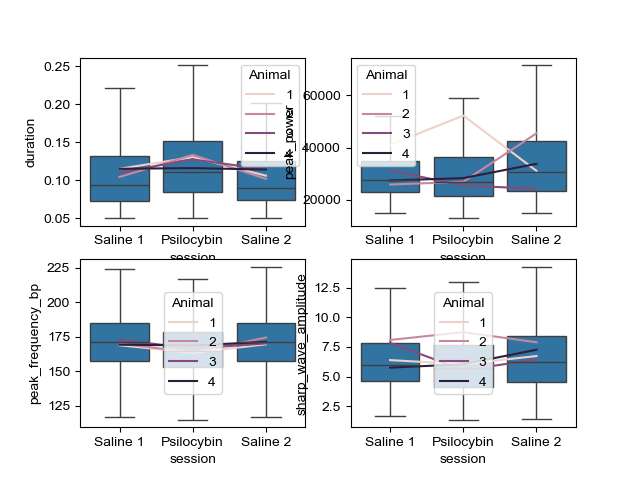

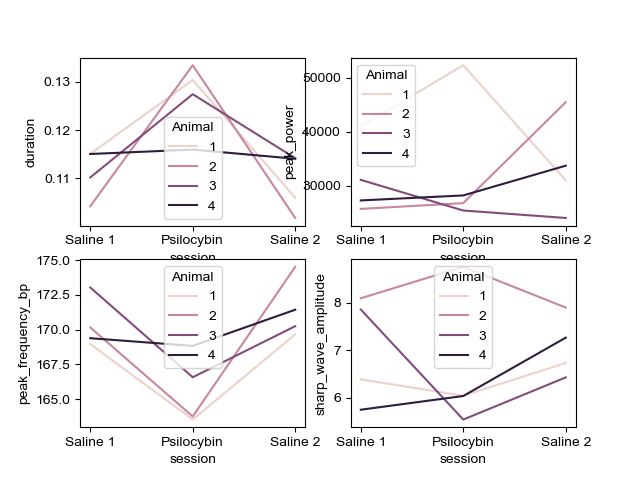

In [16]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    # sns.violinplot(data=df_grp, x="session", y=feature, cut=0.1, inner="quart", ax=a)
    sns.boxplot(data=df_grp, x="session", y=feature, showfliers=False, ax=a)
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)
    # sal1_df = df_grp[df_grp.session == "Saline 1"]
    # psi_df = df_grp[df_grp.session == "Psilocybin"]
    # sal2_df = df_grp[df_grp.session == "Saline 2"]

    # sal1_v_psi = stats.mannwhitneyu(sal1_df[feature].values, psi_df[feature].values)
    # psi_v_sal2 = stats.mannwhitneyu(psi_df[feature].values, sal2_df[feature].values)
    # sal1_v_sal2 = stats.mannwhitneyu(sal1_df[feature].values, sal2_df[feature].values)

    print(f"FEATURE: {feature}")
    for grps_use in [["Saline 1", "Psilocybin"], ["Psilocybin", "Saline 2"], ["Saline 1", "Saline 2"]]:
        grp1_vals = df_grp[df_grp.session == grps_use[0]][feature].values
        grp2_vals = df_grp[df_grp.session == grps_use[1]][feature].values
        print(f"{grps_use[0]} mean = {np.mean(grp1_vals)}, {grps_use[1]} mean = {np.mean(grp2_vals)}")
        mannu_stats = stats.mannwhitneyu(grp1_vals, grp2_vals)
        print(f"Mann-Whitney U test p-value={mannu_stats.pvalue}\n")
    print("\n")

_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)

In [ ]:
df_split = df_grp[np.isin(df_grp.session.values, ["Saline 1", "Psilocybin"])]

In [ ]:
_, ax = plt.subplots()
df_split = df_grp[np.isin(df_grp.session.values, ["Saline 1", "Psilocybin"])]
sns.violinplot(data=df_split, y="duration", hue="session", split=True, ax=ax)

In [ ]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.boxenplot(data=df_grp, x="session", y=feature, ax=a)